## Fine-tune SegFormer on a custom dataset

In this notebook, we are going to fine-tune [SegFormerForSemanticSegmentation](https://huggingface.co/docs/transformers/main/model_doc/segformer#transformers.SegformerForSemanticSegmentation) on a custom **semantic segmentation** dataset. In semantic segmentation, the goal for the model is to label each pixel of an image with one of a list of predefined classes.

We load the encoder of the model with weights pre-trained on ImageNet-1k, and fine-tune it together with the decoder head, which starts with randomly initialized weights.

In [ ]:
!pip install -q transformers datasets evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 15.6 MB/s eta 0:00:00


## Download toy dataset

Here we download a small subset of the ADE20k dataset, which is an important benchmark for semantic segmentation. It contains 150 labels.

I've made a small subset just for demonstration purposes (namely the 10 first training and 10 first validation images + segmentation maps). The goal for the model is to overfit this tiny dataset (because that makes sure that it'll work on a larger scale).

In [ ]:
import requests, zipfile, io

def download_data():
    url = "https://www.dropbox.com/s/l1e45oht447053f/ADE20k_toy_dataset.zip?dl=1"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()

download_data()

Note that this dataset is now also available on the hub :) you can directly check out the images [in your browser](scene_parse_150)! It can be easily loaded as follows (note that loading will take some time as the dataset is several GB's large):

In [ ]:
from datasets import load_dataset

load_entire_dataset = False

if load_entire_dataset:
  dataset = load_dataset("scene_parse_150")

## Define PyTorch dataset and dataloaders

Here we define a [custom PyTorch dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html). Each item of the dataset consists of an image and a corresponding segmentation map.

In [ ]:
from torch.utils.data import Dataset
import os
from PIL import Image

class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, image_processor, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            image_processor (SegFormerImageProcessor): image processor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.image_processor = image_processor
        self.train = train

        sub_path = "training" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, "images", sub_path)
        self.ann_dir = os.path.join(self.root_dir, "annotations", sub_path)

        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
          image_file_names.extend(files)
        self.images = sorted(image_file_names)

        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
          annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = Image.open(os.path.join(self.img_dir, self.images[idx]))
        segmentation_map = Image.open(os.path.join(self.ann_dir, self.annotations[idx]))

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.image_processor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

Let's initialize the training + validation datasets. Important: we initialize the image processor with `reduce_labels=True`, as the classes in ADE20k go from 0 to 150, with 0 meaning "background". However, we want the labels to go from 0 to 149, and only train the model to recognize the 150 classes (which don't include "background"). Hence, we'll reduce all labels by 1 and replace 0 by 255, which is the `ignore_index` of SegFormer's loss function.

In [ ]:
from transformers import SegformerImageProcessor

root_dir = '/content/ADE20k_toy_dataset'
image_processor = SegformerImageProcessor(reduce_labels=True)

train_dataset = SemanticSegmentationDataset(root_dir=root_dir, image_processor=image_processor)
valid_dataset = SemanticSegmentationDataset(root_dir=root_dir, image_processor=image_processor, train=False)

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/image_processing_segformer.py:102: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 10
Number of validation examples: 10


Let's verify a random example:

In [ ]:
encoded_inputs = train_dataset[0]

In [ ]:
encoded_inputs["pixel_values"].shape

torch.Size([3, 512, 512])

In [ ]:
encoded_inputs["labels"].shape

torch.Size([512, 512])

In [ ]:
encoded_inputs["labels"]

tensor([[255, 255, 255,  ...,   5,   5,   5],
        [255,   5,   5,  ...,   5,   5,   5],
        [255,   5,   5,  ...,   5,   5,   5],
        ...,
        [  3,   3,   3,  ...,   0,   0, 255],
        [  3,   3,   3,  ...,   0,   0, 255],
        [  3,   3,   3,  ...,   0,   0,   0]])

In [ ]:
encoded_inputs["labels"].squeeze().unique()

tensor([  0,   3,   4,   5,  12,  17,  31,  32,  42,  43,  87,  96, 104, 125,
        138, 149, 255])

Next, we define corresponding dataloaders.

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=2)

In [ ]:
batch = next(iter(train_dataloader))

In [ ]:
for k,v in batch.items():
  print(k, v.shape)

pixel_values torch.Size([2, 3, 512, 512])
labels torch.Size([2, 512, 512])


In [ ]:
batch["labels"].shape

torch.Size([2, 512, 512])

In [ ]:
mask = (batch["labels"] != 255)
mask

tensor([[[ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         ...,
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         [False, False, False,  ...,  True,  True, False]],

        [[False, False, False,  ...,  True,  True,  True],
         [False,  True,  True,  ...,  True,  True,  True],
         [False,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True,  True]]])

In [ ]:
batch["labels"][mask]

tensor([0, 0, 0,  ..., 0, 0, 0])

## Define the model

Here we load the model, and equip the encoder with weights pre-trained on ImageNet-1k (we take the smallest variant, `nvidia/mit-b0` here, but you can take a bigger one like `nvidia/mit-b5` from the [hub](https://huggingface.co/models?other=segformer)). We also set the `id2label` and `label2id` mappings, which will be useful when performing inference.

In [ ]:
from transformers import SegformerForSemanticSegmentation
import json
from huggingface_hub import hf_hub_download

# load id2label mapping from a JSON on the hub
repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(hf_hub_download(repo_id=repo_id, filename=filename, repo_type="dataset"), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

# define model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=150,
                                                         id2label=id2label,
                                                         label2id=label2id,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


ade20k-id2label.json:   0%|          | 0.00/2.81k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/14.4M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Fine-tune the model

Here we fine-tune the model in native PyTorch, using the AdamW optimizer. We use the same learning rate as the one reported in the [paper](https://arxiv.org/abs/2105.15203).

It's also very useful to track metrics during training. For semantic segmentation, typical metrics include the mean intersection-over-union (mIoU) and pixel-wise accuracy. These are available in the Datasets library. We can load it as follows:

In [ ]:
import evaluate

metric = evaluate.load("mean_iou")

In [ ]:
image_processor.do_reduce_labels

True

In [ ]:
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()
for epoch in range(200):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   for idx, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        loss.backward()
        optimizer.step()

        # evaluate
        with torch.no_grad():
          upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
          predicted = upsampled_logits.argmax(dim=1)

          # note that the metric expects predictions + labels as numpy arrays
          metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        # let's print loss and metrics every 100 batches
        if idx % 100 == 0:
          # currently using _compute instead of compute
          # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
          metrics = metric._compute(
                  predictions=predicted.cpu(),
                  references=labels.cpu(),
                  num_labels=len(id2label),
                  ignore_index=255,
                  reduce_labels=False, # we've already reduced the labels ourselves
              )

          print("Loss:", loss.item())
          print("Mean_iou:", metrics["mean_iou"])
          print("Mean accuracy:", metrics["mean_accuracy"])

Epoch: 0


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


Loss: 5.027858257293701
Mean_iou: 0.00019864918373361254
Mean accuracy: 0.004599010923027884
Epoch: 1


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.879627704620361
Mean_iou: 0.000991404842172833
Mean accuracy: 0.006151910001686169
Epoch: 2


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.7052836418151855
Mean_iou: 0.010044808386449961
Mean accuracy: 0.06088056457859062
Epoch: 3


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.618570804595947
Mean_iou: 0.01713364418256847
Mean accuracy: 0.11627023969185289
Epoch: 4


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.586825370788574
Mean_iou: 0.01404944107020128
Mean accuracy: 0.12001231470964173
Epoch: 5


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.390036582946777
Mean_iou: 0.03323493261593083
Mean accuracy: 0.47783926535384563
Epoch: 6


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.918002128601074
Mean_iou: 0.08363436365868068
Mean accuracy: 0.39054550308586
Epoch: 7


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.248713970184326
Mean_iou: 0.055970414895122035
Mean accuracy: 0.43091988798418474
Epoch: 8


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.4960248470306396
Mean_iou: 0.10297463656047637
Mean accuracy: 0.2968889454723703
Epoch: 9


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.868389368057251
Mean_iou: 0.07296240029072878
Mean accuracy: 0.30122117880285887
Epoch: 10


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.696945905685425
Mean_iou: 0.10052241174570083
Mean accuracy: 0.3639247434985346
Epoch: 11


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.8243637084960938
Mean_iou: 0.10331385134090779
Mean accuracy: 0.22757480115080886
Epoch: 12


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.194622278213501
Mean_iou: 0.14343046143383095
Mean accuracy: 0.3332251930012978
Epoch: 13


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.531512498855591
Mean_iou: 0.5278355926139607
Mean accuracy: 0.7072694723684706
Epoch: 14


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.8963472843170166
Mean_iou: 0.2454190893224568
Mean accuracy: 0.5251783579576458
Epoch: 15


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.918959856033325
Mean_iou: 0.17044936203262304
Mean accuracy: 0.27770162387582614
Epoch: 16


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.264024019241333
Mean_iou: 0.21959447010638514
Mean accuracy: 0.6640739206071059
Epoch: 17


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.186445474624634
Mean_iou: 0.18919158469239317
Mean accuracy: 0.36184801637600295
Epoch: 18


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.6107003688812256
Mean_iou: 0.2202380226333369
Mean accuracy: 0.2752434970256858
Epoch: 19


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.8147971630096436
Mean_iou: 0.36677644842917223
Mean accuracy: 0.5435327444771955
Epoch: 20


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.349996566772461
Mean_iou: 0.2742793437006772
Mean accuracy: 0.39306361389036637
Epoch: 21


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.262324094772339
Mean_iou: 0.33044103539556074
Mean accuracy: 0.42545013552112065
Epoch: 22


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.329293966293335
Mean_iou: 0.10530862732414818
Mean accuracy: 0.17496075291068858
Epoch: 23


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.6461873054504395
Mean_iou: 0.1697847780216404
Mean accuracy: 0.22678698323415847
Epoch: 24


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.367915153503418
Mean_iou: 0.34809554048905883
Mean accuracy: 0.4652547473632882
Epoch: 25


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.847838282585144
Mean_iou: 0.3599522910642592
Mean accuracy: 0.4830074889134375
Epoch: 26


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.1377604007720947
Mean_iou: 0.3423083514164914
Mean accuracy: 0.4547021124610737
Epoch: 27


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4054611921310425
Mean_iou: 0.6260619769758954
Mean accuracy: 0.829393651192407
Epoch: 28


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.8827519416809082
Mean_iou: 0.2905791709286926
Mean accuracy: 0.5337092258750774
Epoch: 29


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.3644964694976807
Mean_iou: 0.1882271969585776
Mean accuracy: 0.2741982333308745
Epoch: 30


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.242588758468628
Mean_iou: 0.2098501558891745
Mean accuracy: 0.2966040543891548
Epoch: 31


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.237476348876953
Mean_iou: 0.33188936335683134
Mean accuracy: 0.5116566954751874
Epoch: 32


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.3003084659576416
Mean_iou: 0.2041523286796815
Mean accuracy: 0.2809739872332325
Epoch: 33


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.823930025100708
Mean_iou: 0.20533380059592773
Mean accuracy: 0.3236671659852661
Epoch: 34


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.9612903594970703
Mean_iou: 0.38600025302927926
Mean accuracy: 0.5382024927975283
Epoch: 35


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.2011752128601074
Mean_iou: 0.2008397240395293
Mean accuracy: 0.2910985454936392
Epoch: 36


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4600777626037598
Mean_iou: 0.33121124256721346
Mean accuracy: 0.5605367886897612
Epoch: 37


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5803583860397339
Mean_iou: 0.18841790688087165
Mean accuracy: 0.37485785051435
Epoch: 38


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4145479202270508
Mean_iou: 0.2359505403516997
Mean accuracy: 0.33084876843473165
Epoch: 39


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.8043171167373657
Mean_iou: 0.5649941408765004
Mean accuracy: 0.8009062387011594
Epoch: 40


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.6035786867141724
Mean_iou: 0.22124296640500907
Mean accuracy: 0.3293710292335137
Epoch: 41


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7262722253799438
Mean_iou: 0.5974735597778428
Mean accuracy: 0.7895981622011291
Epoch: 42


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.6204859018325806
Mean_iou: 0.24289266999146825
Mean accuracy: 0.37315231010848465
Epoch: 43


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.8074121475219727
Mean_iou: 0.12114744530815057
Mean accuracy: 0.20068491148504106
Epoch: 44


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.6035388708114624
Mean_iou: 0.19580597147400844
Mean accuracy: 0.30935517391648837
Epoch: 45


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.346091628074646
Mean_iou: 0.21044313261029102
Mean accuracy: 0.3797153547429424
Epoch: 46


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9670596122741699
Mean_iou: 0.7419198744718685
Mean accuracy: 0.7890479802276875
Epoch: 47


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8139573335647583
Mean_iou: 0.5682629434905742
Mean accuracy: 0.7846342431331671
Epoch: 48


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2550514936447144
Mean_iou: 0.23768890460542855
Mean accuracy: 0.38171048304719624
Epoch: 49


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5363426208496094
Mean_iou: 0.5021092684177887
Mean accuracy: 0.6156318178868336
Epoch: 50


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.333264946937561
Mean_iou: 0.24300460821873027
Mean accuracy: 0.28566115686847576
Epoch: 51


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5453397631645203
Mean_iou: 0.431437020962619
Mean accuracy: 0.6138232835263114
Epoch: 52


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4344006776809692
Mean_iou: 0.21301368736696702
Mean accuracy: 0.33157087335648566
Epoch: 53


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.6167645454406738
Mean_iou: 0.4255143161544882
Mean accuracy: 0.5256242057377222
Epoch: 54


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2314152717590332
Mean_iou: 0.3793980151936074
Mean accuracy: 0.49960025274543496
Epoch: 55


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.447384238243103
Mean_iou: 0.4354530543463644
Mean accuracy: 0.6164744468264657
Epoch: 56


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1940463781356812
Mean_iou: 0.7229128105861058
Mean accuracy: 0.7871965174358713
Epoch: 57


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.629187285900116
Mean_iou: 0.6874867745063059
Mean accuracy: 0.7865886866605675
Epoch: 58


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8638954758644104
Mean_iou: 0.3301025638267742
Mean accuracy: 0.5495198716333966
Epoch: 59


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6242767572402954
Mean_iou: 0.8053694867341377
Mean accuracy: 0.829662474988993
Epoch: 60


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.40435078740119934
Mean_iou: 0.4365013948639113
Mean accuracy: 0.6183458535666144
Epoch: 61


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.118537425994873
Mean_iou: 0.4520541606422921
Mean accuracy: 0.7070282651861165
Epoch: 62


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0981892347335815
Mean_iou: 0.26837741178881647
Mean accuracy: 0.35400824303526873
Epoch: 63


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2068088054656982
Mean_iou: 0.35185478763413625
Mean accuracy: 0.5380371397548769
Epoch: 64


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9496510028839111
Mean_iou: 0.8016102261559206
Mean accuracy: 0.8541785103903204
Epoch: 65


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2392051219940186
Mean_iou: 0.5350401308727434
Mean accuracy: 0.6122985020341298
Epoch: 66


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.48520082235336304
Mean_iou: 0.823583379286128
Mean accuracy: 0.8648283237505401
Epoch: 67


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9825624823570251
Mean_iou: 0.27055024259282223
Mean accuracy: 0.37254865458489766
Epoch: 68


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9644943475723267
Mean_iou: 0.39872212147939307
Mean accuracy: 0.5205613005331913
Epoch: 69


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0358887910842896
Mean_iou: 0.2898417526791469
Mean accuracy: 0.3775424069133036
Epoch: 70


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0441443920135498
Mean_iou: 0.5126870876433969
Mean accuracy: 0.5902091879620736
Epoch: 71


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6643358469009399
Mean_iou: 0.49411555968404575
Mean accuracy: 0.5898914733849279
Epoch: 72


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1420069932937622
Mean_iou: 0.39400519056968447
Mean accuracy: 0.5837833917041452
Epoch: 73


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1072345972061157
Mean_iou: 0.43289560466391797
Mean accuracy: 0.5236351172596403
Epoch: 74


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8733721971511841
Mean_iou: 0.15843032887917333
Mean accuracy: 0.23922208487921454
Epoch: 75


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6646602153778076
Mean_iou: 0.3834617103962079
Mean accuracy: 0.6859830833595717
Epoch: 76


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7690394520759583
Mean_iou: 0.4502230540666602
Mean accuracy: 0.5291511030630262
Epoch: 77


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1479500532150269
Mean_iou: 0.19852420628212397
Mean accuracy: 0.28945993936069486
Epoch: 78


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9707426428794861
Mean_iou: 0.26281827144776077
Mean accuracy: 0.33686562972349743
Epoch: 79


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9255504608154297
Mean_iou: 0.3771120957437052
Mean accuracy: 0.4483014938783773
Epoch: 80


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.30653226375579834
Mean_iou: 0.40349852327882596
Mean accuracy: 0.6228135508290786
Epoch: 81


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8906108736991882
Mean_iou: 0.324646153513479
Mean accuracy: 0.4096999171489884
Epoch: 82


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8315125107765198
Mean_iou: 0.24330132037470617
Mean accuracy: 0.36595982502246094
Epoch: 83


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.361390084028244
Mean_iou: 0.759737720336593
Mean accuracy: 0.8854094757121467
Epoch: 84


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9898300170898438
Mean_iou: 0.41104623575867777
Mean accuracy: 0.4911506597329044
Epoch: 85


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0598241090774536
Mean_iou: 0.3159791091684477
Mean accuracy: 0.38276603244894086
Epoch: 86


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.797118604183197
Mean_iou: 0.2065820717700415
Mean accuracy: 0.29337338711403005
Epoch: 87


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0777509212493896
Mean_iou: 0.33373916183721675
Mean accuracy: 0.42351380572487274
Epoch: 88


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.794527530670166
Mean_iou: 0.3766049461393565
Mean accuracy: 0.5313262006685237
Epoch: 89


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.613139808177948
Mean_iou: 0.401268913695538
Mean accuracy: 0.5058574693254206
Epoch: 90


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.512426495552063
Mean_iou: 0.5054662210629443
Mean accuracy: 0.6897567701596953
Epoch: 91


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9075947403907776
Mean_iou: 0.2879683045064601
Mean accuracy: 0.33931660622201437
Epoch: 92


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7170641422271729
Mean_iou: 0.16715607019640655
Mean accuracy: 0.2604014771410566
Epoch: 93


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5918509364128113
Mean_iou: 0.5189188173055488
Mean accuracy: 0.593000694461539
Epoch: 94


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7128376960754395
Mean_iou: 0.536276776927965
Mean accuracy: 0.6224650333194542
Epoch: 95


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6572757363319397
Mean_iou: 0.41889415990230366
Mean accuracy: 0.5455388881157052
Epoch: 96


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2615414261817932
Mean_iou: 0.8273603290426988
Mean accuracy: 0.850415292120776
Epoch: 97


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8506656885147095
Mean_iou: 0.39811715473342524
Mean accuracy: 0.4659290652163056
Epoch: 98


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.009224534034729
Mean_iou: 0.33925541039912294
Mean accuracy: 0.4666016290049278
Epoch: 99


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.737300455570221
Mean_iou: 0.6429138970263788
Mean accuracy: 0.6730289537580509
Epoch: 100


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1932336837053299
Mean_iou: 0.4875765455647056
Mean accuracy: 0.6830910203150279
Epoch: 101


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8479088544845581
Mean_iou: 0.5057480528989206
Mean accuracy: 0.570144269766766
Epoch: 102


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5930994749069214
Mean_iou: 0.2865655449068016
Mean accuracy: 0.5274218062099467
Epoch: 103


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.24739713966846466
Mean_iou: 0.8318511245075023
Mean accuracy: 0.8572142055706787
Epoch: 104


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6732589602470398
Mean_iou: 0.5500979600713944
Mean accuracy: 0.626238637265869
Epoch: 105


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6965868473052979
Mean_iou: 0.17684718012023204
Mean accuracy: 0.2444123138423514
Epoch: 106


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6558808088302612
Mean_iou: 0.6399893676417364
Mean accuracy: 0.6696689436567966
Epoch: 107


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7307891845703125
Mean_iou: 0.4596209311136701
Mean accuracy: 0.5492162320928126
Epoch: 108


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9207662343978882
Mean_iou: 0.39051537384884366
Mean accuracy: 0.46467496616681364
Epoch: 109


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.37945204973220825
Mean_iou: 0.5349669200576069
Mean accuracy: 0.591340584681256
Epoch: 110


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5982568860054016
Mean_iou: 0.29526731012098467
Mean accuracy: 0.3663531426161068
Epoch: 111


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5716835856437683
Mean_iou: 0.5954952380488294
Mean accuracy: 0.6415667790427815
Epoch: 112


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6321594715118408
Mean_iou: 0.3143419539274267
Mean accuracy: 0.4600828609284596
Epoch: 113


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.33765909075737
Mean_iou: 0.43395675992680627
Mean accuracy: 0.6935870297881799
Epoch: 114


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7383995056152344
Mean_iou: 0.4034823797499454
Mean accuracy: 0.4625375542073845
Epoch: 115


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.35533419251441956
Mean_iou: 0.5100363594395853
Mean accuracy: 0.7407438904403321
Epoch: 116


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.18288862705230713
Mean_iou: 0.8389782547114343
Mean accuracy: 0.8569955415361504
Epoch: 117


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8465012311935425
Mean_iou: 0.34360048673048493
Mean accuracy: 0.4789508897579205
Epoch: 118


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.30405646562576294
Mean_iou: 0.4489862603356457
Mean accuracy: 0.7162775351520083
Epoch: 119


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7364172339439392
Mean_iou: 0.2351809069421568
Mean accuracy: 0.324575671503719
Epoch: 120


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7455177903175354
Mean_iou: 0.39581435721288494
Mean accuracy: 0.4499307935212346
Epoch: 121


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6185641288757324
Mean_iou: 0.31029090448609997
Mean accuracy: 0.4342417456033052
Epoch: 122


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3583155572414398
Mean_iou: 0.5868016986669792
Mean accuracy: 0.6578846254859303
Epoch: 123


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5821224451065063
Mean_iou: 0.4693745075775584
Mean accuracy: 0.5311661618731995
Epoch: 124


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8800448179244995
Mean_iou: 0.5939398628195972
Mean accuracy: 0.6669395406569739
Epoch: 125


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4231719672679901
Mean_iou: 0.8845168283657387
Mean accuracy: 0.9150008625245888
Epoch: 126


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.505970299243927
Mean_iou: 0.44102837355238306
Mean accuracy: 0.48936061425763183
Epoch: 127


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5593234896659851
Mean_iou: 0.593353913166855
Mean accuracy: 0.66775255335273
Epoch: 128


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7380058169364929
Mean_iou: 0.4730578125675696
Mean accuracy: 0.6217060564926385
Epoch: 129


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5524451732635498
Mean_iou: 0.5557190674871595
Mean accuracy: 0.6699621953687392
Epoch: 130


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.475918173789978
Mean_iou: 0.8244400306726647
Mean accuracy: 0.8735856992305159
Epoch: 131


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6538088321685791
Mean_iou: 0.2374081320104601
Mean accuracy: 0.33932408434566036
Epoch: 132


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3738839626312256
Mean_iou: 0.8398024066014617
Mean accuracy: 0.8776730911796367
Epoch: 133


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2741278111934662
Mean_iou: 0.495735606081326
Mean accuracy: 0.7033702739009798
Epoch: 134


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.448564738035202
Mean_iou: 0.4627591197091641
Mean accuracy: 0.5095350971068842
Epoch: 135


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5797538161277771
Mean_iou: 0.5351997813486151
Mean accuracy: 0.5787976271548038
Epoch: 136


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.66171795129776
Mean_iou: 0.42167601402801064
Mean accuracy: 0.47699355182589065
Epoch: 137


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4898841083049774
Mean_iou: 0.6615025916865755
Mean accuracy: 0.6901728718983247
Epoch: 138


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5827524662017822
Mean_iou: 0.4463236242592122
Mean accuracy: 0.5385093642065466
Epoch: 139


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4911358058452606
Mean_iou: 0.2266024348834735
Mean accuracy: 0.28784003941784525
Epoch: 140


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.555121123790741
Mean_iou: 0.3080592520533878
Mean accuracy: 0.35067701298610365
Epoch: 141


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.43273741006851196
Mean_iou: 0.37905112394010915
Mean accuracy: 0.5340996631401814
Epoch: 142


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4898540675640106
Mean_iou: 0.6597837308255229
Mean accuracy: 0.6908716873733437
Epoch: 143


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.368254154920578
Mean_iou: 0.41910335180496144
Mean accuracy: 0.576624422145969
Epoch: 144


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4346211552619934
Mean_iou: 0.4536179279194072
Mean accuracy: 0.5215756097152293
Epoch: 145


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6278572082519531
Mean_iou: 0.3489639062388545
Mean accuracy: 0.40961265492477333
Epoch: 146


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.400214821100235
Mean_iou: 0.47107683686823415
Mean accuracy: 0.6045746422046107
Epoch: 147


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.40624725818634033
Mean_iou: 0.7340639652936208
Mean accuracy: 0.7753452119504544
Epoch: 148


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1782509684562683
Mean_iou: 0.7368757032160282
Mean accuracy: 0.8508723396369278
Epoch: 149


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.46275630593299866
Mean_iou: 0.5490842249626051
Mean accuracy: 0.5956904849392851
Epoch: 150


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5055887699127197
Mean_iou: 0.5904256956041005
Mean accuracy: 0.6249942766475831
Epoch: 151


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3648413121700287
Mean_iou: 0.9193290710541417
Mean accuracy: 0.9450046346926252
Epoch: 152


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5012395977973938
Mean_iou: 0.37605153797553137
Mean accuracy: 0.4412444439709474
Epoch: 153


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.33637353777885437
Mean_iou: 0.5077891204045423
Mean accuracy: 0.6059428926594835
Epoch: 154


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4329957365989685
Mean_iou: 0.32602532461227657
Mean accuracy: 0.44372820647261185
Epoch: 155


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5488935112953186
Mean_iou: 0.5222962265317802
Mean accuracy: 0.5655694452930292
Epoch: 156


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4155520498752594
Mean_iou: 0.23384851569801923
Mean accuracy: 0.34665105365297005
Epoch: 157


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5374839305877686
Mean_iou: 0.5362256153827961
Mean accuracy: 0.598412664708119
Epoch: 158


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5572863221168518
Mean_iou: 0.5349016493771012
Mean accuracy: 0.5812196760748989
Epoch: 159


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5873227715492249
Mean_iou: 0.31203540059528073
Mean accuracy: 0.3999819379514507
Epoch: 160


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4050188660621643
Mean_iou: 0.4164765067848806
Mean accuracy: 0.5362326657924389
Epoch: 161


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5195820331573486
Mean_iou: 0.5253658698465044
Mean accuracy: 0.5662368860078753
Epoch: 162


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.29607686400413513
Mean_iou: 0.4011552066854682
Mean accuracy: 0.5682680514692784
Epoch: 163


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.09525038301944733
Mean_iou: 0.47494419397597776
Mean accuracy: 0.7229595044670426
Epoch: 164


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.20487917959690094
Mean_iou: 0.5011351642484764
Mean accuracy: 0.7847074411478284
Epoch: 165


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.31550174951553345
Mean_iou: 0.7425574409065641
Mean accuracy: 0.868063664552821
Epoch: 166


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4122500419616699
Mean_iou: 0.5164320071023153
Mean accuracy: 0.5934787059572025
Epoch: 167


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4036726951599121
Mean_iou: 0.3775511512268174
Mean accuracy: 0.4004515591404884
Epoch: 168


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.49561816453933716
Mean_iou: 0.3715928955489789
Mean accuracy: 0.432293180083266
Epoch: 169


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2935902178287506
Mean_iou: 0.4289630464888225
Mean accuracy: 0.5573608554570902
Epoch: 170


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4719005823135376
Mean_iou: 0.5300680427445669
Mean accuracy: 0.6771142833787841
Epoch: 171


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.40568816661834717
Mean_iou: 0.4219245480413081
Mean accuracy: 0.5475098927811869
Epoch: 172


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3952862620353699
Mean_iou: 0.7374243044033798
Mean accuracy: 0.7690996639841694
Epoch: 173


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4039211571216583
Mean_iou: 0.3931616034129814
Mean accuracy: 0.4701650552440878
Epoch: 174


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.31081005930900574
Mean_iou: 0.5775507713388973
Mean accuracy: 0.6174314779550625
Epoch: 175


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5041756629943848
Mean_iou: 0.28105378041921986
Mean accuracy: 0.3710009593149439
Epoch: 176


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3814079165458679
Mean_iou: 0.38951365774852814
Mean accuracy: 0.4588548727587448
Epoch: 177


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.33575811982154846
Mean_iou: 0.608499241909819
Mean accuracy: 0.6519809778583001
Epoch: 178


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.45893925428390503
Mean_iou: 0.5845232759509649
Mean accuracy: 0.6221268271182696
Epoch: 179


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.37815141677856445
Mean_iou: 0.3946065695102673
Mean accuracy: 0.46462366687908735
Epoch: 180


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3456801474094391
Mean_iou: 0.3753277757111225
Mean accuracy: 0.4450705377198682
Epoch: 181


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.28956636786460876
Mean_iou: 0.6003997146147299
Mean accuracy: 0.641993740593701
Epoch: 182


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.23853573203086853
Mean_iou: 0.7654453395105316
Mean accuracy: 0.8856724545789638
Epoch: 183


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.29271382093429565
Mean_iou: 0.750886363096746
Mean accuracy: 0.7832180734659291
Epoch: 184


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3309544324874878
Mean_iou: 0.674055725199523
Mean accuracy: 0.7094772279483581
Epoch: 185


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2760562002658844
Mean_iou: 0.6191259095425357
Mean accuracy: 0.6906634279436918
Epoch: 186


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2842766344547272
Mean_iou: 0.755839820118238
Mean accuracy: 0.7875240772653745
Epoch: 187


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2844476103782654
Mean_iou: 0.49062312863856083
Mean accuracy: 0.6189925335945716
Epoch: 188


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.34082457423210144
Mean_iou: 0.5481972768878295
Mean accuracy: 0.5928656873046948
Epoch: 189


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3417707681655884
Mean_iou: 0.5975102231073094
Mean accuracy: 0.6542793261411466
Epoch: 190


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.0903850644826889
Mean_iou: 0.8469645810955175
Mean accuracy: 0.8640827748317815
Epoch: 191


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3695440888404846
Mean_iou: 0.3802622032413125
Mean accuracy: 0.4715215458716183
Epoch: 192


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5246599316596985
Mean_iou: 0.5412042381266495
Mean accuracy: 0.6010780885571321
Epoch: 193


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3191053867340088
Mean_iou: 0.564503168378677
Mean accuracy: 0.6458119094325236
Epoch: 194


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.21077728271484375
Mean_iou: 0.8034525270586582
Mean accuracy: 0.9335473568362735
Epoch: 195


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.17693431675434113
Mean_iou: 0.5371442099340331
Mean accuracy: 0.6298293840416653
Epoch: 196


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3382582664489746
Mean_iou: 0.6212497148390722
Mean accuracy: 0.6663382143190054
Epoch: 197


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3107702434062958
Mean_iou: 0.7280736024121561
Mean accuracy: 0.7487148844761438
Epoch: 198


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2724965512752533
Mean_iou: 0.5664001581707188
Mean accuracy: 0.6545363289175613
Epoch: 199


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.44378799200057983
Mean_iou: 0.39749579013955405
Mean accuracy: 0.44747739714676676


## Inference

Finally, let's check whether the model has really learned something.

Let's test the trained model on an image (refer to my [inference notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SegFormer/Segformer_inference_notebook.ipynb) for details):

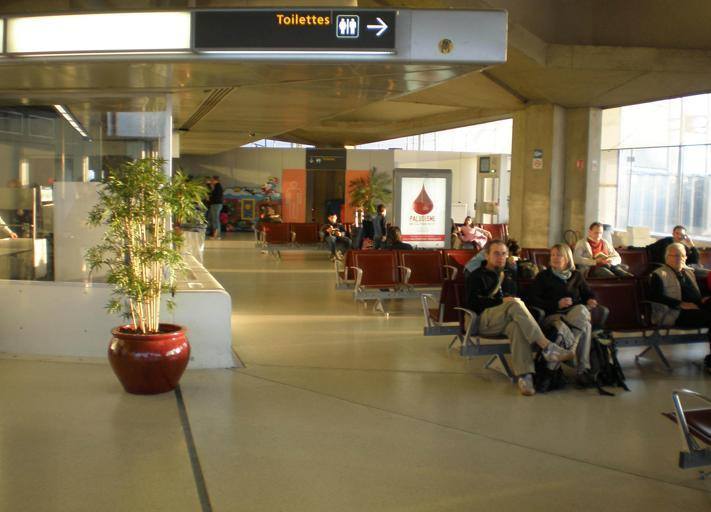

In [ ]:
image = Image.open('/content/ADE20k_toy_dataset/images/training/ADE_train_00000002.jpg')
image

In [ ]:
# prepare the image for the model
pixel_values = image_processor(image, return_tensors="pt").pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [ ]:
import torch

# forward pass
with torch.no_grad():
  outputs = model(pixel_values=pixel_values)

In [ ]:
# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 150, 128, 128])


In [ ]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

In [ ]:
predicted_segmentation_map = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()
print(predicted_segmentation_map)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]]


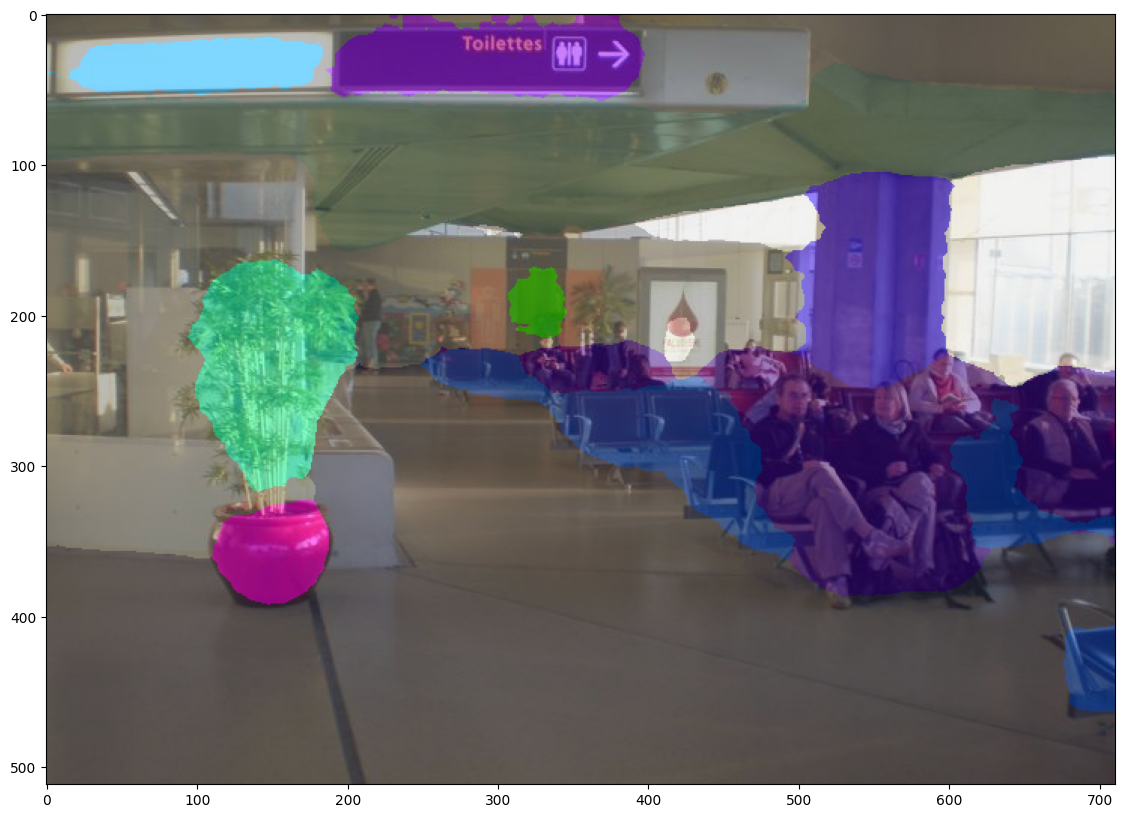

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

color_seg = np.zeros((predicted_segmentation_map.shape[0],
                      predicted_segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3

palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[predicted_segmentation_map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Compare this to the ground truth segmentation map:

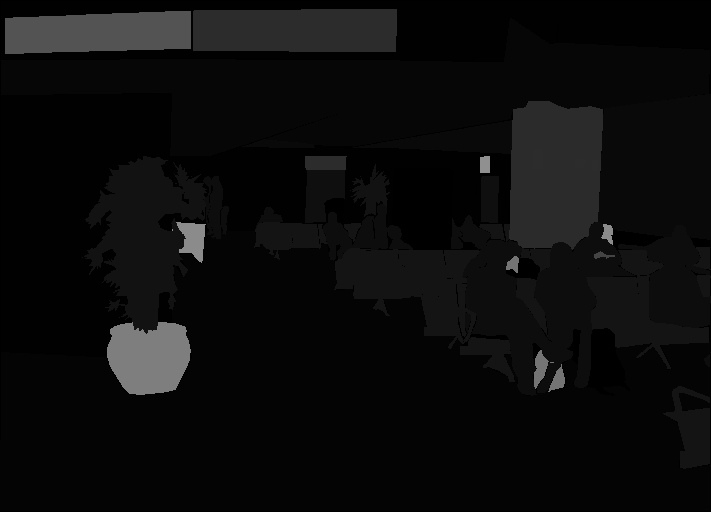

In [ ]:
map = Image.open('/content/ADE20k_toy_dataset/annotations/training/ADE_train_00000002.png')
map

Classes in this image: ['wall', 'floor', 'ceiling', 'windowpane', 'person', 'door', 'plant', 'chair', 'column', 'signboard', 'book', 'light', 'bag', 'pot', 'ashcan', 'monitor', None]


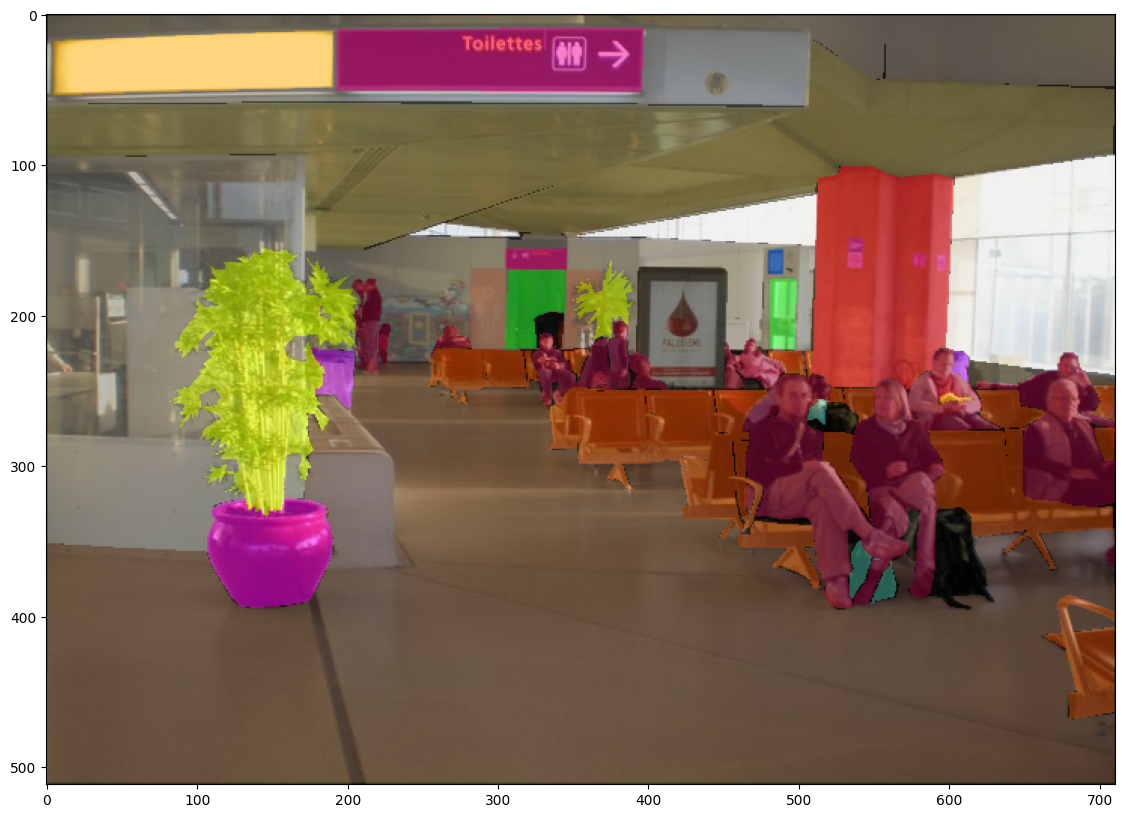

In [ ]:
# convert map to NumPy array
import cv2
map = np.array(map)
map[map == 0] = 255 # background class is replaced by ignore_index
map = map - 1 # other classes are reduced by one
map[map == 254] = 255

classes_map = np.unique(map).tolist()
unique_classes = [model.config.id2label[idx] if idx!=255 else None for idx in classes_map]
print("Classes in this image:", unique_classes)

# create coloured map
color_seg = np.zeros((map.shape[0], map.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[map == label, :] = color
# Convert to BGR
color_seg = cv2.resize(color_seg, (img.shape[1], img.shape[0]))

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Let's compute the metrics:

In [ ]:
# metric expects a list of numpy arrays for both predictions and references
metrics = metric._compute(
                  predictions=[predicted_segmentation_map],
                  references=[map],
                  num_labels=len(id2label),
                  ignore_index=255,
                  reduce_labels=False, # we've already reduced the labels ourselves
              )

/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


In [ ]:
metrics.keys()

dict_keys(['mean_iou', 'mean_accuracy', 'overall_accuracy', 'per_category_iou', 'per_category_accuracy'])

In [ ]:
import pandas as pd

# print overall metrics
for key in list(metrics.keys())[:3]:
  print(key, metrics[key])

# pretty-print per category metrics as Pandas DataFrame
metric_table = dict()
for id, label in id2label.items():
    metric_table[label] = [
                           metrics["per_category_iou"][id],
                           metrics["per_category_accuracy"][id]
    ]

print("---------------------")
print("per-category metrics:")
pd.DataFrame.from_dict(metric_table, orient="index", columns=["IoU", "accuracy"])

mean_iou 0.5756918535956759
mean_accuracy 0.6252382549422201
overall_accuracy 0.9179921709950477
---------------------
per-category metrics:


IoU  accuracy
wall      0.812005  0.944578
building       NaN       NaN
sky            NaN       NaN
floor     0.961213  0.980520
tree           NaN       NaN
...            ...       ...
shower         NaN       NaN
radiator       NaN       NaN
glass          NaN       NaN
clock          NaN       NaN
flag           NaN       NaN

[150 rows x 2 columns]

In [ ]:
metric_table

{'wall': [0.812005007250598, 0.9445782090283885],
 'building': [nan, nan],
 'sky': [nan, nan],
 'floor': [0.9612132022186236, 0.9805203096321123],
 'tree': [nan, nan],
 'ceiling': [0.9333492490667593, 0.9523440441127622],
 'road': [nan, nan],
 'bed ': [nan, nan],
 'windowpane': [0.9129423222594957, 0.9626312186216339],
 'grass': [nan, nan],
 'cabinet': [nan, nan],
 'sidewalk': [nan, nan],
 'person': [0.6776946976680666, 0.8817858729453576],
 'earth': [nan, nan],
 'door': [0.43232157506152585, 0.44211409395973156],
 'table': [nan, nan],
 'mountain': [nan, nan],
 'plant': [0.707204092920354, 0.8058772551800205],
 'curtain': [nan, nan],
 'chair': [0.6266613679516051, 0.6831616443631462],
 'car': [nan, nan],
 'water': [nan, nan],
 'painting': [nan, nan],
 'sofa': [nan, nan],
 'shelf': [nan, nan],
 'house': [nan, nan],
 'sea': [nan, nan],
 'mirror': [nan, nan],
 'rug': [nan, nan],
 'field': [nan, nan],
 'armchair': [nan, nan],
 'seat': [nan, nan],
 'fence': [nan, nan],
 'desk': [nan, nan],
